In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Helper Functions 
* Primary functions for the detection of lit and un-lit segments

In [6]:
# Function to define segments within a digit's bounding box given by four coordinate pairs
def define_segments(corners):
    
    # get the coordidnate pairs from the list of tuples
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = corners

    # define the extents of detection segments within the bounding box
    segments = {
        'A': (x1, y1, x2, y1 + (y3 - y1) * 0.2),
        'B': (x2 - (x2 - x1) * 0.2, y1, x2, y2 + (y3 - y1) * 0.5),
        'C': (x3 - (x3 - x4) * 0.2, y3 - (y3 - y2) * 0.5, x3, y3),
        'D': (x4, y4 - (y4 - y1) * 0.2, x3, y4),
        'E': (x1, y4 - (y4 - y1) * 0.5, x1 + (x2 - x1) * 0.2, y4),
        'F': (x1, y1, x1 + (x2 - x1) * 0.2, y1 + (y3 - y1) * 0.5),
        'G': (x1 + (x2 - x1) * 0.2, y1 + (y3 - y1) * 0.45, x2 - (x2 - x1) * 0.2, y1 + (y3 - y1) * 0.55)
    }
    
    # returns the detection segments
    return segments

# Function to check if a segment meets the threshold to be lit with defaults of 127 and 20%
def is_segment_lit(segment, img, threshold=127, lit_percentage=0.2):
    
    # apply the segments to the image
    x1, y1, x2, y2 = segment
    segment_img = img[int(y1):int(y2), int(x1):int(x2)]
    
    # calculate the number of pixels above the threshold (white pixels)
    white_pixels = np.sum(segment_img > threshold)
    # calculate the total number of pixels in the segment
    total_pixels = segment_img.size
    # calculate the percentage of white pixels
    white_percentage = white_pixels / total_pixels
    
    # check if the percentage of white pixels is greater than the lit_percentage
    # in the future this could be updated to return the percent if that stat is desired to be reported on
    return white_percentage >= lit_percentage

# Map for the different combinations of lit segments
digit_map = {
    (True, True, True, True, True, True, False): '0',
    (False, True, True, False, False, False, False): '1',
    (True, True, False, True, True, False, True): '2',
    (True, True, True, True, False, False, True): '3',
    (False, True, True, False, False, True, True): '4',
    (True, False, True, True, False, True, True): '5',
    (True, False, True, True, True, True, True): '6',
    (True, True, True, False, False, False, False): '7',
    (True, True, True, True, True, True, True): '8',
    (True, True, True, True, False, True, True): '9'
}

# Function to determine the displayed digit using the defined digit map
def identify_digit(segments, img, threshold=127, lit_percentage=0.2):
    lit_segments = tuple(is_segment_lit(segments[s], img, threshold, lit_percentage) for s in 'ABCDEFG')
    return digit_map.get(lit_segments, None)


### Locating the First Number

* Function to iterate over the image to locate the first number in the serise and return bounding box

In [8]:
def find_first_number(corners, incr, img, thresh, percent): 
    
    count = 0
    digit = None
    
    height, width = img.shape

    # while no digit has been detected run through the loop
    while digit == None:

        # increment by the specfied value (defaults to 1 pixel)
        corners = [(x + incr, y) for (x, y) in corners]

        segments = define_segments(corners)

        digit = identify_digit(segments, img, threshold=thresh, lit_percentage=percent)

        # if the bounding box has exceeded the image, no metadata has been found
        if count == width - 11:
            print('No Metadata Detected')
            break 

        count = count + 1
        
    return digit, corners

### Function to Determine All Digits

In [9]:
def find_all_number(corners, size_numbers, size_spaces, spacing, img, thresh, percent): 

    height, width = img.shape
    x = width
    
    results = []
    
    corners = [(x + 1, y) for (x, y) in corners]
    segments = define_segments(corners)

    digit = identify_digit(segments, img, threshold=thresh, lit_percentage=percent)
    
    results.append(digit)
    
    for i in range(len(spacing)):

        # increment the digit by the specified map of spacing
        current_corner = [(x + size_numbers * spacing[i][0] + size_spaces * spacing[i][1], y) for (x, y) in corners]

        segments = define_segments(current_corner)

        digit = identify_digit(segments, img, threshold=thresh, lit_percentage=percent)
        
        # if the next digit after the first is not in the expected pattern then it is out of phase left
        if i == 0 and digit == None:
            corners = [(x - size_numbers, y) for (x, y) in corners]
            results.append('Out of Phase Left')
            continue

        # checks if the bounding box has ever exceeded the image
        if bool([tuple for tuple in corners if any(x <= i for i in tuple)]): 
            results.append('Out of Phase Right')
            break

            
        results.append(digit)
        
    return results

## Running the Functions

### Current Limitations//Needed Work 

* If the image is very far out of phase-left, i.e several digits are cut off, the rest of the digits will not be mapped properly

* As the metadata is only several pixels wide, it is sensitive to changes in both the sizing of the bounding box and the thresholds that are used. As such, the accuracy varies image to image. Therefore, it might be worth exploring defining a dynamic threshold such as through using Otsu's method or similar.

* The sizes of the segments of the bounding box could maybe fined tuned a little more.


In [10]:
# specify the image, just have the current image in the directory as img
image_path =  'Image0018_T.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [11]:
# this inital bounding box is defined to the very right of the image in the desired vertical position
intial_corner = [(0, 20), (11, 20), (11, 39), (0, 39)]

# thresh defines the brightness//whiteness of the pixel, whereas the percent is how many need to be above the thresh
thresh = 110
percent = 0.40

[digit, corners] = find_first_number(intial_corner, 1, img, thresh, percent)

In [12]:
# spacing map defines the number of positions to move//increment
# the first column is the number of digits, and second number of spaces
spacing_map = [[1, 0], [1, 1], [2, 1], [2, 2], 
               [3, 2], [3, 3], [4, 3], [5, 3], 
               [5, 4], [6, 4], [7, 4], [8, 4], 
               [8, 5], [9, 5]]

size_numbers = 20
size_spaces = 39
thresh = 110
percent = 0.3

if digit is not None: 
    results = find_all_number(corners, size_numbers, size_spaces, spacing_map, img, thresh, percent)

print(results)

['4', '1', '8', '1', '7', None, '0', '5', '9', None, '0', '0', '3', '3', '7']


### Helper Visulization (useful for debugging)

The digit within the new bounding box is: 4
Segments status with lit threshold for the second digit:
Segment A: Not Lit
Segment B: Lit
Segment C: Lit
Segment D: Not Lit
Segment E: Not Lit
Segment F: Lit
Segment G: Lit


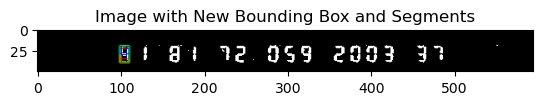

In [13]:
thresh = 110
percent = 0.4

# you can do x +/- n to move it n pixels
n = 0 
corners = [(x + n, y) for (x, y) in corners]

# any bounding box defined by the corners will be tested, same format as inital_corner

segments = define_segments(corners)

digit = identify_digit(segments, img, threshold=thresh, lit_percentage=percent)

segments_lit = {seg: is_segment_lit(segments[seg], img, threshold=thresh, lit_percentage=percent) for seg in segments}

# Specifices which segments are lit and the predicted digit
print(f"The digit within the new bounding box is: {digit}")
print("Segments status with lit threshold for the second digit:")
for seg, lit in segments_lit.items():
    status = "Lit" if lit else "Not Lit"
    print(f"Segment {seg}: {status}")

# Creates bounding box and segments for visulization
img_with_new_bbox_and_segments = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for corner_start, corner_end in zip(corners, corners[1:] + corners[:1]):
    cv2.line(img_with_new_bbox_and_segments, corner_start, corner_end, (0, 255, 0), 2)

for seg, coords in segments.items():
    x1, y1, x2, y2 = map(int, coords)
    color = (255, 0, 0) if segments_lit[seg] else (0, 0, 255)
    cv2.rectangle(img_with_new_bbox_and_segments, (x1, y1), (x2, y2), color, 1)


    plt.imshow(cv2.cvtColor(img_with_new_bbox_and_segments, cv2.COLOR_BGR2RGB))
plt.title('Image with New Bounding Box and Segments')
plt.show()
